In [ ]:
import os
import pandas as pd
import numpy as np
import ast
import json
import re
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import dcg_score
from sklearn.metrics import ndcg_score
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax

import tempfile

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as score

from  matplotlib import ticker
from  matplotlib.ticker import FuncFormatter
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
s2vmodel = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
measures = ['ClicksRel','ClicksKeyrel','ClicksIrrel',
            'DwellIrrel','MissRel']

behaviors = ['QueryLength','UniqueTerm','NewTerm','QuerySim',
             'PageVisit','ClickCount',
             'AvgClickRank','Clicks@3','Clicks@5','Clicks@5+','ClickDepth',
             'TimeFirstClick','TimeLastClick','ContentDwellTime','QueryDwellTime']

def queryTermsCompare(query, last_query):
    query = splitKeyWord(query)
    last_query = splitKeyWord(last_query)
    new_unique_term = [word for word in query if (word not in last_query)]
    shared_unique_term = [word for word in query if (word in last_query)]
    total_unique_term = [word for word in query] + [word for word in last_query]
    unique_term = len(set(total_unique_term))
    new_term = len(set(new_unique_term))/len(set(total_unique_term))
    shared_term = len(set(shared_unique_term))/len(set(total_unique_term))
    return unique_term, new_term, shared_term


def splitKeyWord(query):
    regex = r"[\u4e00-\ufaff]|[0-9]+|[a-zA-Z]+\'*[a-z]*"
    matches = re.findall(regex, query, re.UNICODE)
    return matches

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/track2014_rawfeatures.csv', encoding='UTF-8')

data[measures] = 0
data[behaviors] = 0

# data['ClicksRel'] = 0
# data['ClicksKeyrel'] = 0
# data['ClicksUse'] = 0

# data['ClicksIrrel'] = 0
# data['ClicksNonuse'] = 0
# data['DwellIrrel'] = 0
# data['DwellNonuse'] = 0
# data['MissRel'] = 0

data_eval = pd.DataFrame(columns=data.columns)

sessions_list = list(data['session'].drop_duplicates().values)
for session in sessions_list:
    data_s = data.loc[data['session']==session].copy()
    query_unique = {}
    query_all = []
    last_query = ''
    query_interval = list(data_s['starttime_query'].values[1:]-data_s['starttime_query'].values[:-1])
    last_query_interval = ast.literal_eval(data_s['starttime_act'].values[-1])
    if last_query_interval != []:
        last_query_interval = max(last_query_interval) - data_s['starttime_query'].values[-1]
    else:
        last_query_interval = 0
    query_interval.append(last_query_interval)

    data_s['dwelltime_query'] = query_interval


    query_order = 1
    for index, row in data_s.iterrows():
        row['query_order'] = query_order
        query_order += 1
        row['QueryToken'] = word_tokenize(row['query'])
        row['QueryToken'] = [w.lower() for w in row['QueryToken'] if w.lower() not in stop_words]
        row['TokenLength'] = len(row['QueryToken'])
        row['QueryLength'] = len(splitKeyWord(row['query']))
        row['UniqueTerm'] = queryTermsCompare(row['query'],last_query)[0]
        if row['query'] in query_all:
            row['NewTerm'] = 0
            row['QuerySim'] = 0
        else:
            row['NewTerm'] = queryTermsCompare(row['query'],last_query)[1]
            row['QuerySim'] = queryTermsCompare(row['query'],last_query)[2]
        query_all.append(row['query'])
        last_query = row['query']

        actions = ast.literal_eval(row['action'])
        # row['ActionCount'] = len(actions)
        # row['ScrollDist'] = row['distance']
        # row['HoverCount'] = actions.count('HOVER')
        row['PageVisit'] = actions.count('PAGINATION')

        clicks = ast.literal_eval(row['click'])
        clicks = list(map(int, clicks))
        click_time = ast.literal_eval(row['click_time'])

        row['ClickPage'] = len(set(clicks))
        row['ClickCount'] = len(clicks)
        row['AvgClickRank'] = sum(clicks)/len(clicks) + 1 if clicks else 0
        row['Clicks@3'] = len([item for item in clicks if item < 3])
        row['Clicks@5'] = len([item for item in clicks if item < 5])
        row['Clicks@5+'] = len([item for item in clicks if item >= 5])
        row['ClickDepth'] = max(clicks)+1 if clicks else 0
        row['TimeFirstClick'] = click_time[0] if clicks else 0
        row['TimeLastClick'] = click_time[-1] if clicks else 0

        row['click'] = ast.literal_eval(row['click'])
        row['dwelltime_doc'] = ast.literal_eval(row['dwelltime_doc'])

        row['ContentDwellTime'] = sum(row['dwelltime_doc'])

        row['QueryDwellTime'] = row['dwelltime_query']

        relevance_t = dict(ast.literal_eval(row['relevance']))

        relevance_list = [relevance_t[i] if i in relevance_t else 0
                          for i in range(int(max(relevance_t))+1)] if relevance_t else [0]

        relevance_ideal = relevance_list.copy()
        relevance_ideal.sort(reverse=True)

        if len(relevance_list)>1:
            ndcg_r = ndcg_score(np.array([relevance_list]),np.array([relevance_ideal]))
        elif len(relevance_list)==1 and relevance_list != [0]:
            ndcg_r = 1
        else:
            ndcg_r = 0


        rr_r = relevance_list.index(max(relevance_list))+1 if max(relevance_list)!=0 else 11

        dcg_rel = sum([relevance_list[i]/math.log(i+2,2) for i in range(len(relevance_list))])

        if row['query'] not in query_unique:
            query_unique[row['query']] = row['click']
            unique_query = True
        else:
            unique_query = False
            dcg_rel = 0
            dcg_use = 0

        row['dcg_rel'] = dcg_rel

        row['ndcg_r'] = ndcg_r
        row['rr_r'] = rr_r

        Rel_t = { key: value for key, value in relevance_t.items() if value >= 1}

        for i in range(len(clicks)):
            relevance_i = relevance_t[clicks[i]] if clicks[i] in relevance_t else 0
            dwelltime_i = row['dwelltime_doc'][i] if i < len(row['dwelltime_doc']) else 0

            if clicks[i] in Rel_t:
                del Rel_t[clicks[i]]

            if not (not unique_query and row['click'][i] in query_unique[row['query']]):

                row['ClicksRel'] += 1 if relevance_i >= 1 else 0
                row['ClicksKeyrel'] += 1 if relevance_i >= 3 else 0
            elif not unique_query:
                query_unique[row['query']].append(row['click'][i])

            row['ClicksIrrel'] += 1 if relevance_i <= 0 else 0
            row['DwellIrrel'] += dwelltime_i if relevance_i <= 0 else 0

        row['MissRel'] = len(Rel_t)

        data_eval = data_eval.append(row, ignore_index = True)


In [ ]:
query_vec = s2vmodel.encode(data_eval['query'])
data_eval['vector'] = query_vec.tolist()

In [ ]:
eval_list = ['dcg_rel','ClicksRel','ClicksKeyrel',
             'ClicksIrrel','DwellIrrel','MissRel']
eval_list_ratet = [item+'_ratet' for item in eval_list]
eval_list_ratep = [item+'_ratep' for item in eval_list]

In [ ]:
eval_session = pd.DataFrame()
active_data_eval = pd.DataFrame()

for session in sessions_list:
    eval_dict = {}
    eval_dict['session'] = session

    data_s = data_eval.loc[data_eval['session']==session]

    if data_s['ClickCount'].sum() == 0:
        continue
    active_data_eval = active_data_eval.append(data_s, ignore_index=True)
    eval_dict['user'] = data_s['user'].values[0]
    eval_dict['task'] = data_s['task'].values[0]

    session_dwell = data_s['dwelltime_query'].sum()
    session_clickpage = data_s['ClickPage'].sum()

    for e in eval_list:
        eval_dict[e] = data_s[e].sum()
        eval_dict[e+'_ratet'] = eval_dict[e]/session_dwell
        eval_dict[e+'_ratep'] = eval_dict[e]/session_clickpage

    eval_session = eval_session.append(eval_dict, ignore_index=True)


In [ ]:
len(eval_session)

641

In [ ]:
len(set(eval_session['task']))

60

In [ ]:
len(active_data_eval)

2014

In [ ]:
gain_cost_pair = [['dcg_rel','ClicksIrrel'],
                  ['ClicksRel','ClicksIrrel'],
                  ['ClicksRel','DwellIrrel'],
                  ['ClicksRel','MissRel']]


In [ ]:
eval_list.remove('ClicksKeyrel')

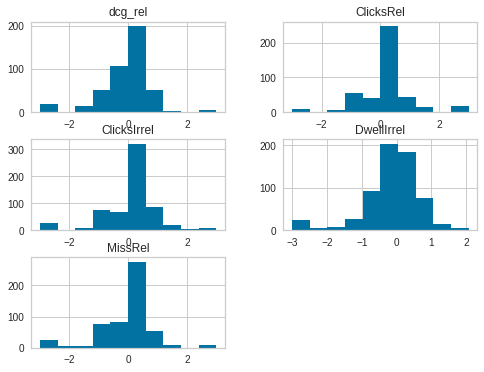

In [ ]:
eval_session_nor = eval_session[eval_list].copy()
eval_session_nor = np.log(eval_session_nor+0.001)
eval_session_nor['task']=eval_session['task']
eval_session_nor=eval_session_nor.groupby('task').transform(
    lambda x: (x - x.median())/(x.quantile(0.80)-x.quantile(0.20)))
# eval_session_nor=eval_session_nor.groupby('task').transform(
#     lambda x: (x - x.mean())/x.std())
eval_session_nor = np.clip(eval_session_nor, -3, 3)
mpl.rcParams['figure.figsize'] = (8, 6)
eval_session_nor.hist()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.show()

In [ ]:
eval_session_nor = eval_session_nor.fillna(0)

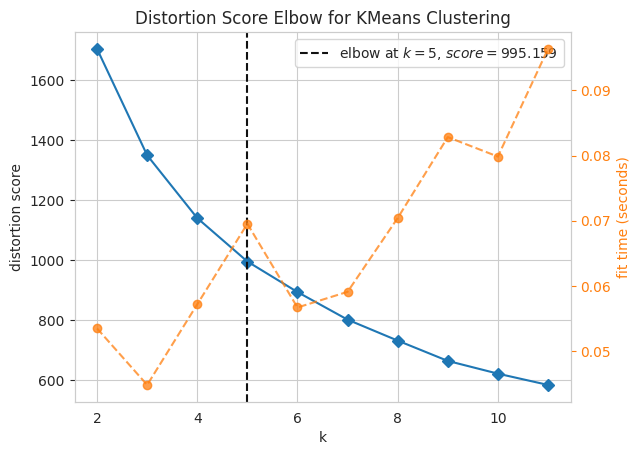

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12),metric='distortion')

visualizer.fit(eval_session_nor)
cluster_n = visualizer.elbow_value_
visualizer.show()

model = KMeans(cluster_n).fit(eval_session_nor)
clusters = eval_session_nor.copy()
clusters['label'] = model.labels_

In [ ]:
for i in range(0,5):
    print(len(clusters.loc[clusters['label']==i]))

73
57
26
344
141


In [ ]:
clusters['label'].replace(0,5,inplace=True)
clusters['label'].replace(2,0,inplace=True)
clusters['label'].replace(5,2,inplace=True)

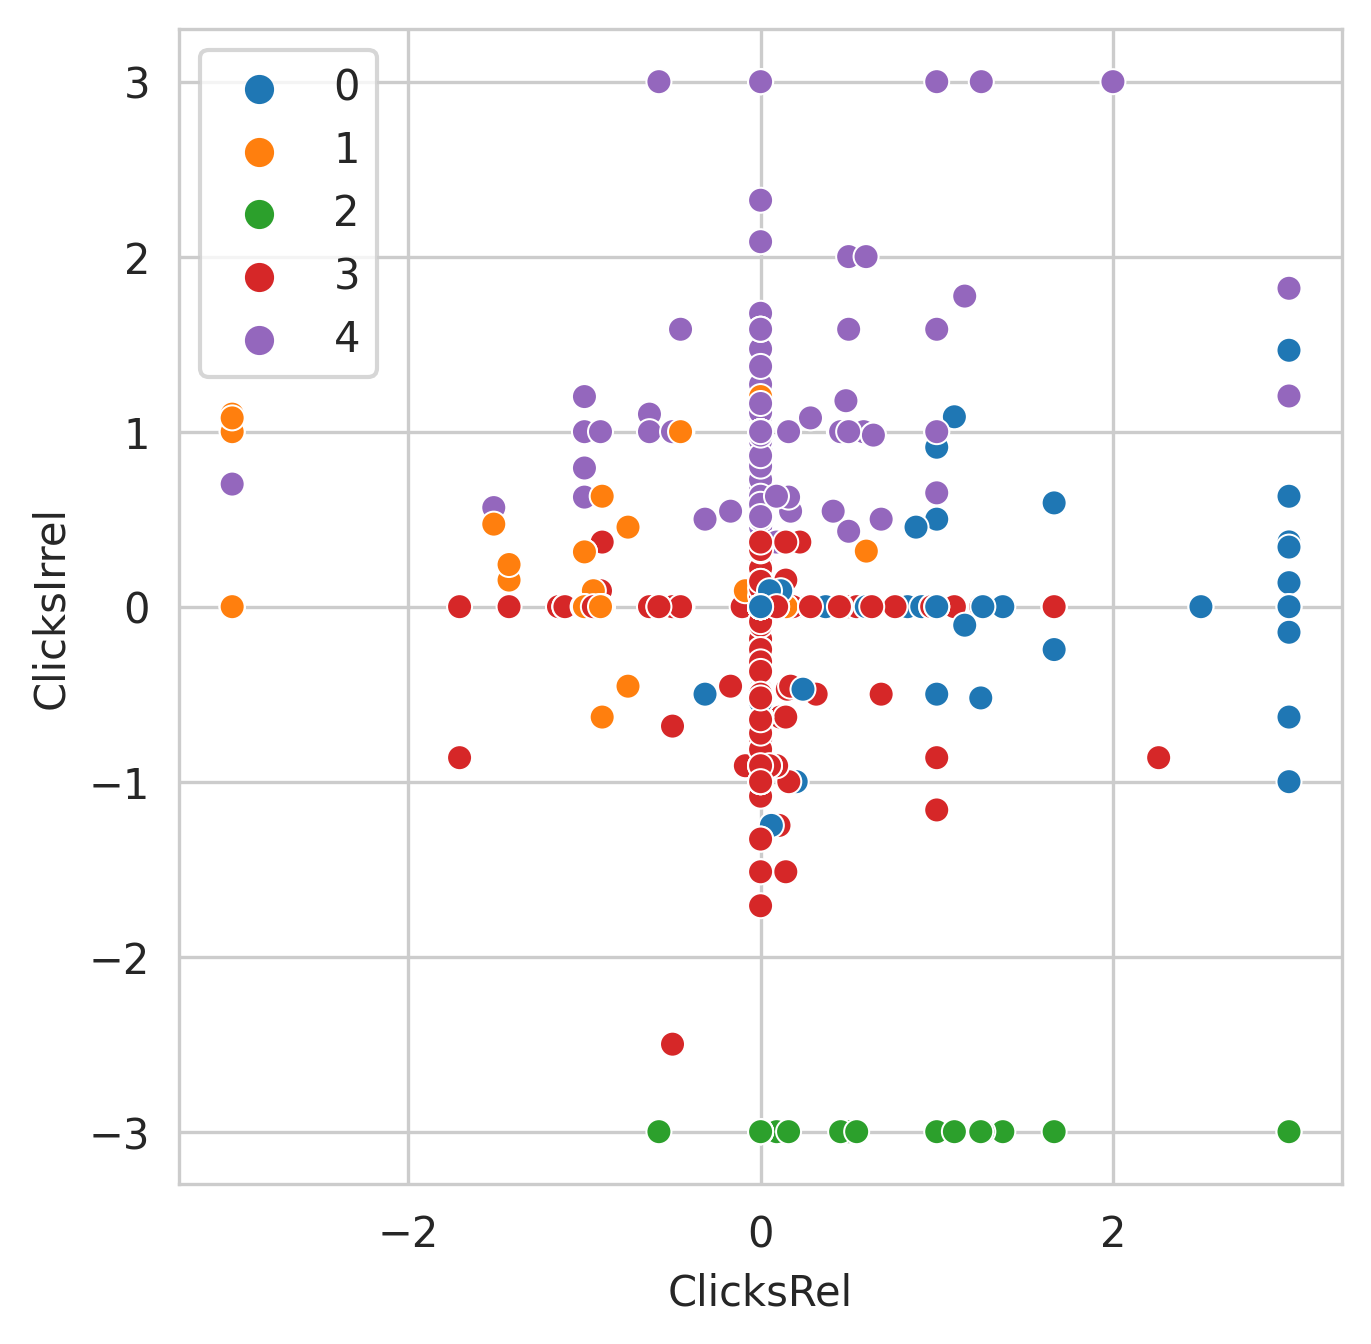

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=300)
sns.scatterplot(x='ClicksRel',y='ClicksIrrel',
                    hue='label',
                    data=clusters,ax=ax,
                    palette="tab10")
plt.legend(frameon=True)
sns.set(font_scale = 1.5)
plt.show()

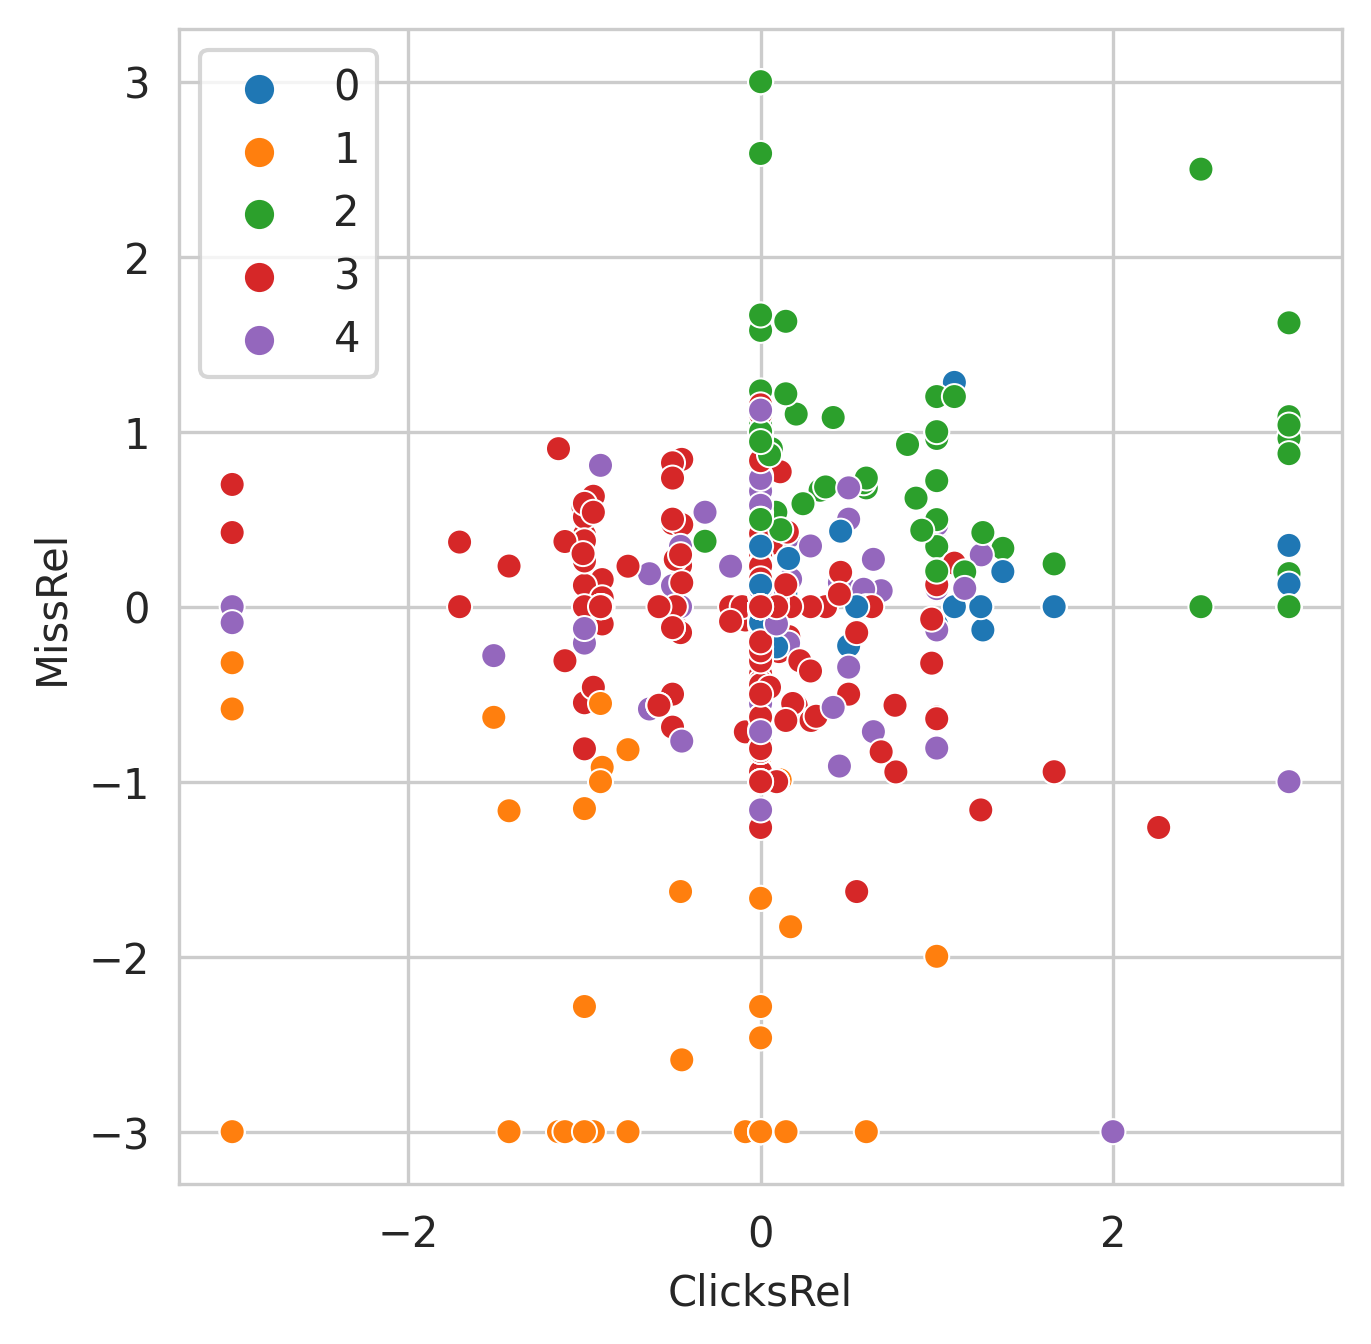

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")
fig, ax = plt.subplots(1,1, figsize=(5,5),dpi=300)
sns.scatterplot(x='ClicksRel',y='MissRel',
                    hue='label',
                    data=clusters,ax=ax,
                    palette="tab10")
plt.legend(frameon=True)
sns.set(font_scale = 1.5)
plt.show()

In [ ]:
clusters.to_csv('/content/drive/MyDrive/Data/trecclusters.csv')

In [ ]:
clusters = pd.read_csv('/content/drive/MyDrive/Data/trecclusters.csv', index_col = [0])

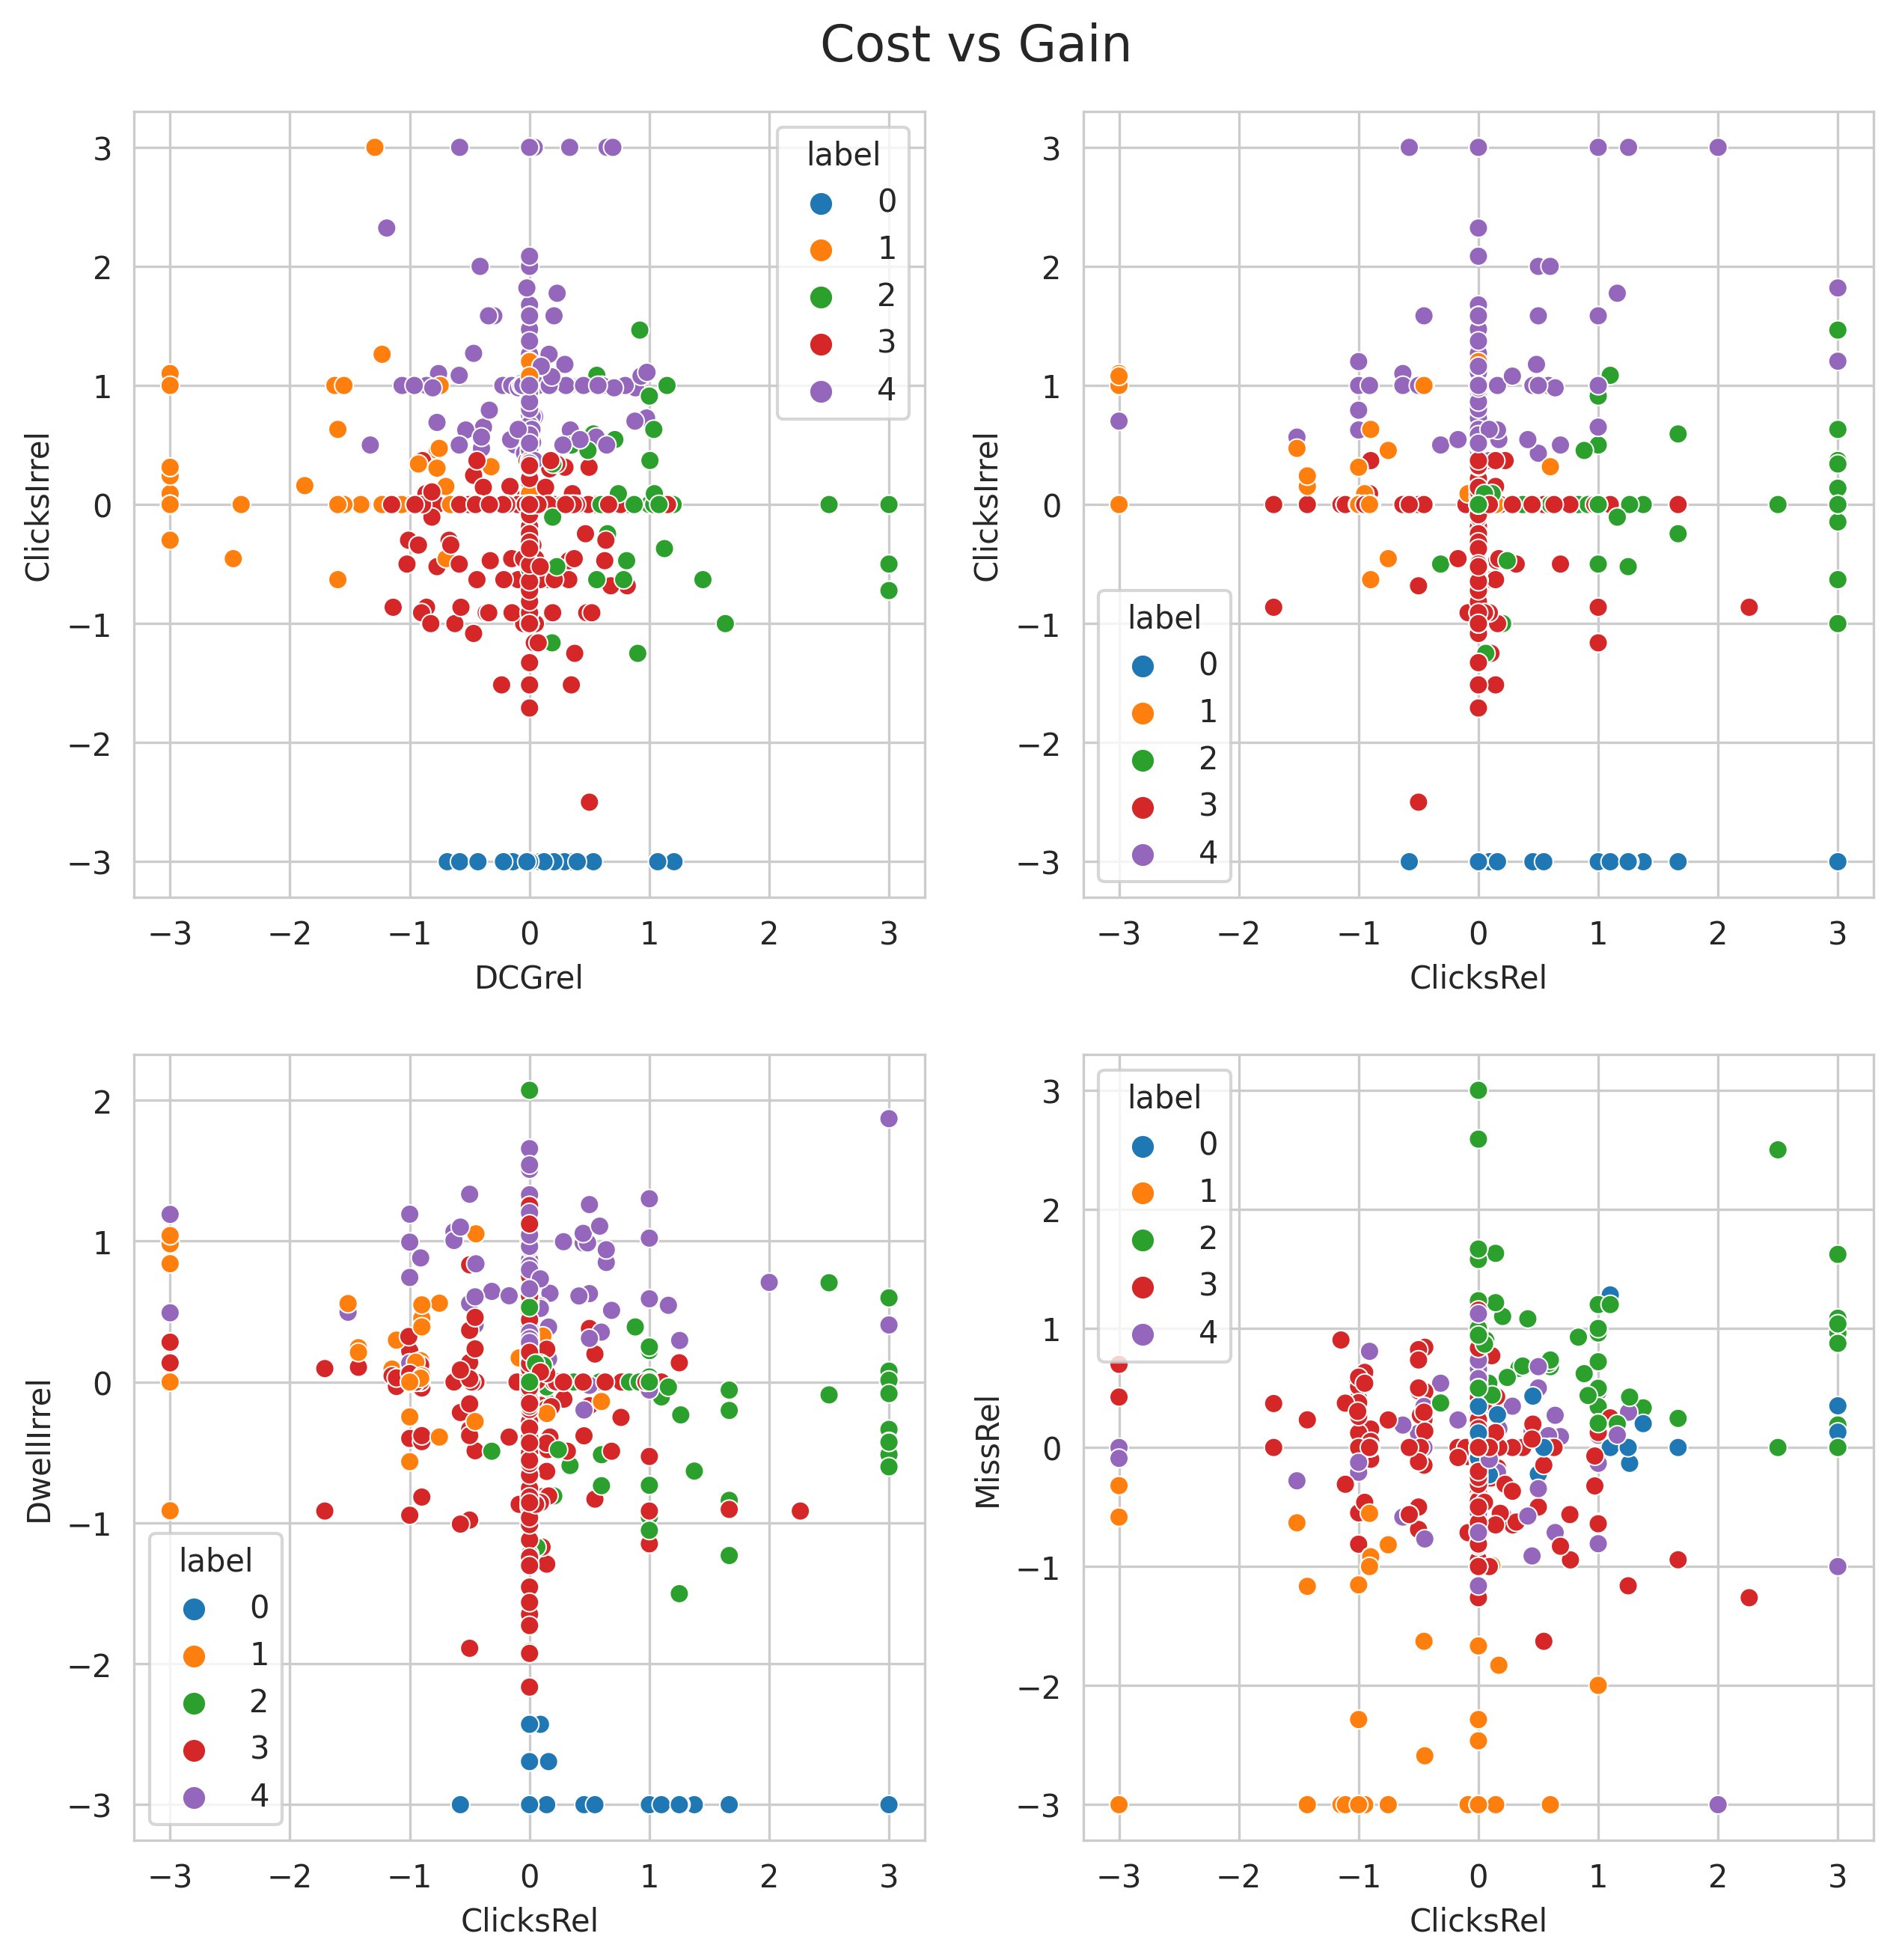

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,2, figsize=(10,10),dpi=300)
for i in range(len(gain_cost_pair)):
    pair = gain_cost_pair[i]
    rename_label = pair[0]
    if 'dcg' in pair[0]:
        rename_label = pair[0].replace('dcg_','DCG')
    ax[i//2,i%2].set_xlabel(rename_label)
    ax[i//2,i%2].set_ylabel(pair[1])

    sns.scatterplot(x=pair[0],y=pair[1],
                    hue='label',
                    data=clusters,ax=ax[i//2,i%2],
                    palette="tab10")

fig.suptitle('Cost vs Gain', fontsize=16, y=0.92)
plt.show()

In [ ]:
tasks_list = list(eval_session['task'].drop_duplicates().values)
clusters['task']=eval_session['task']
clusters['session'] = eval_session['session']

In [ ]:
good_cluster = [0,2]
clusters['label_bi'] = clusters['label'].where(~clusters['label'].isin(good_cluster),other=0)
clusters['label_bi'] = clusters['label_bi'].where(clusters['label_bi']==0,other=1)
clusters['label_bi'] = 1 - clusters['label_bi']

In [ ]:
sum(clusters['label_bi'])

99

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
class Model(tf.keras.Model):
    def __init__(self, output_bias=None):
        super().__init__()
        if output_bias is not None:
            output_bias = tf.keras.initializers.Constant(output_bias)
        self.dense1 = layers.Dense(128)
        self.dense2 = layers.Dense(64, activation='relu')
        self.output = layers.Dense(1, activation='sigmoid',bias_initializer=output_bias)
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.veclayer1 = layer.Dense(768)
        self.veclayer2 = layer.Dense(64, activation='relu')
        self.veclayer3 = layer.Dense(1, activation='sigmoid')

    def call(self, x, vec, training=False):
        # For Keras layers/models, implement `call` instead of `__call__`.
        vec = self.veclayer1(vec)
        vec = self.veclayer2(vec)
        vec = self.veclayer3(vec)
        x = np.concat((x,vec.T),axis=1)
        x = self.dense1(x)
        if training:
            x = self.dropout(x, training=training)
        x = self.dense2(x)
        if training:
            x = self.dropout(x, training=training)
        return self.output(x)

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        layers.Dense(128,
        input_shape=(X_train.shape[-1],)),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid',
                     bias_initializer=output_bias)
        ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    return model


In [ ]:
BATCH_SIZE = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
data_feat = active_data_eval[behaviors].copy()
data_feat = data_feat.astype(float)
data_feat['task'] = active_data_eval['task']

In [ ]:
skew_feat = behaviors.copy()

In [ ]:
data_feat['session'] = active_data_eval['session']
data_feat_avg = pd.DataFrame()
for session in clusters['session'].values:
    data_s = active_data_eval.loc[active_data_eval['session']==session]
    if len(data_s)==0:
        continue
    row = data_s[behaviors].mean()
    row['task'] = data_s['task'].values[0]
    row['QueryNum'] = len(data_s)

    data_feat_avg = data_feat_avg.append(row,ignore_index=True)

In [ ]:
skew_feat_avg = skew_feat.copy()
skew_feat_avg.remove('UniqueTerm')
skew_feat_avg.append('QueryNum')
data_feat_avg[skew_feat_avg] = np.log(data_feat_avg[skew_feat_avg]+0.001)
data_feat_avg['task'] = data_feat['task']
data_feat_avg = data_feat_avg.groupby('task').transform(
    lambda x: (x - x.median())/(x.quantile(0.8) - x.quantile(0.2)
                                if x.quantile(0.75)>x.quantile() else 1))
data_feat_avg = np.clip(data_feat_avg, -3, 3)

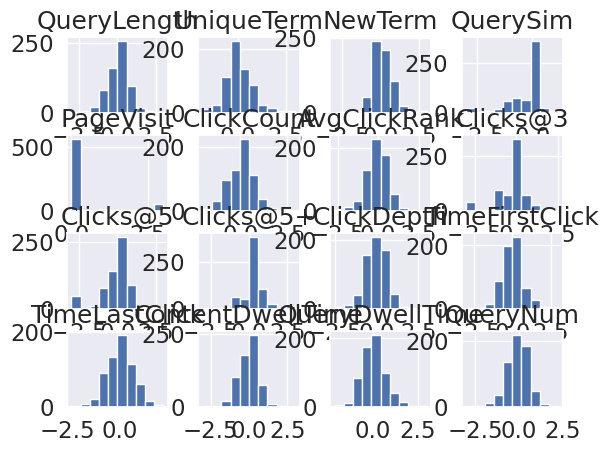

In [ ]:
data_feat_avg.hist()
plt.show()

In [ ]:
def SplitQueryOrder(query_order=None, increment=False):
    data_feat['session'] = active_data_eval['session']
    data_feat_avg = pd.DataFrame()
    for session in clusters['session'].values:
        if query_order == None:
            data_s = active_data_eval.loc[active_data_eval['session']==session]
        else:
            data_s = active_data_eval.loc[active_data_eval['session']==session].head(query_order)
        if increment==True:
            data_s = active_data_eval.loc[active_data_eval['session']==session].head(query_order+1)
            row = data_s[behaviors].diff().mean()
        else:
            row = data_s[behaviors].mean()
        if len(data_s) == 0:
            continue
        row['task'] = data_s['task'].values[0]

        data_feat_avg = data_feat_avg.append(row,ignore_index=True)

    data_feat_avg['task'] = data_feat['task']
    data_feat_avg = data_feat_avg.groupby('task').transform(
        lambda x: (x - x.median())/(x.quantile(0.75) - x.quantile(0.25)
                                    if x.quantile(0.75)>x.quantile() else 1))
    data_feat_avg = np.clip(data_feat_avg, -4, 4)

    behaviors_avg = behaviors.copy()
    behaviors_avg.remove('PageVisit')

    features_array_avg = np.array(data_feat_avg[behaviors_avg])
    # features_array_avg = data_feat_avg[behaviors_avg]

    # pos_features = features_array_avg[np.where(y==1)]
    # neg_features = features_array_avg[np.where(y==0)]

    # pos_labels = y[np.where(y==1)]
    # neg_labels = y[np.where(y==0)]

    # pos_ds = make_ds(pos_features, pos_labels)
    # neg_ds = make_ds(neg_features, neg_labels)

    # resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
    # resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

    return features_array_avg

In [ ]:
X = SplitQueryOrder()
y = clusters['label_bi'].to_numpy()

In [ ]:
pos_features = X[np.where(y==1)]
neg_features = X[np.where(y==0)]
pos_labels = y[np.where(y==1)]
neg_labels = y[np.where(y==0)]

In [ ]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
EPOCHS = 50
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.5


In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*len(neg_labels)/BATCH_SIZE)
resampled_steps_per_epoch

109.0

In [ ]:
#y = clusters['label_bi']
total=len(y)
pos = len(y[(y==1)])
neg = total-pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight_gain = {0: weight_for_0, 1: weight_for_1}
class_weight_gain

{0: 0.5913284132841328, 1: 3.2373737373737375}

In [ ]:
accuracy_hist = {}
precision_hist = {}
recall_hist = {}
f1_hist = {}
model_members = {}
for i in tqdm(range(20)):
    for q in range(1,10):
        X = SplitQueryOrder(query_order=q)
        y = clusters['label_bi'].to_numpy()

        X_train, X_test, y_train, y_test = train_test_split(
            X, y,test_size=0.2,random_state=i)

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,test_size=0.2,random_state=i)

        pos_features = X_train[np.where(y_train==1)]
        neg_features = X_train[np.where(y_train==0)]

        pos_labels = y_train[np.where(y_train==1)]
        neg_labels = y_train[np.where(y_train==0)]

        pos_ds = make_ds(pos_features, pos_labels)
        neg_ds = make_ds(neg_features, neg_labels)

        resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
        resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

        saved_model = os.listdir('/content/drive/MyDrive/Data/')
        if 'track_model_{}_{}'.format(i,q) in saved_model:
            model = tf.keras.models.load_model('/content/drive/MyDrive/Data/track_model_{}_{}'.format(i,q))
        else:
            model = make_model()
            model.fit(
                resampled_ds,
                epochs=50,
                steps_per_epoch=resampled_steps_per_epoch,
                batch_size=BATCH_SIZE,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping],
                # class_weight=class_weight_gain,
                verbose=0)
            model.save('/content/drive/MyDrive/Data/track_model_{}_{}'.format(i,q))

        # model = RandomForestClassifier(class_weight=class_weight_gain, random_state=0)
        # model.fit(X_train, y_train)

        if q not in model_members:
            model_members[q] = [model]
        else:
            model_members[q].append(model)
        # y_pred = model.predict(X_test)
        y_pred = model(X_test)
        y_pred = np.round(y_pred)
        # precision, recall, f1, _ = score(y_test, y_pred, zero_division=0)

        accuracy = accuracy_score(y_test,y_pred)
        precision = precision_score(y_test,y_pred,zero_division=1)
        recall = recall_score(y_test,y_pred)
        f1 = f1_score(y_test,y_pred)

        if q in accuracy_hist:
            accuracy_hist[q].append(accuracy)
            precision_hist[q].append(precision)
            recall_hist[q].append(recall)
            f1_hist[q].append(f1)
        else:
            accuracy_hist[q] = [accuracy]
            precision_hist[q] = [precision]
            recall_hist[q] = [recall]
            f1_hist[q] = [f1]

100%|██████████| 20/20 [22:33<00:00, 67.68s/it]


In [ ]:
model_members = {}
for i in tqdm(range(20)):
    for q in range(1,10):
        model = tf.keras.models.load_model('/content/drive/MyDrive/Data/track_model_{}_{}'.format(i,q))
        if q not in model_members:
            model_members[q] = [model]
        else:
            model_members[q].append(model)

100%|██████████| 20/20 [04:21<00:00, 13.07s/it]


In [ ]:
pred_results = pd.DataFrame()
for q in range(1,10):
    result_dict = {}
    result_dict['QueryOrder'] = q
    result_dict['Accuracy'] = np.mean(accuracy_hist[q])
    # result_dict['Precision'] = [i for i in precision_hist[q] if i != 0]
    # result_dict['Precision'] = np.mean(result_dict['Precision'])
    result_dict['Precision'] = np.mean(precision_hist[q])
    result_dict['Recall'] = np.mean(recall_hist[q])
    result_dict['f1'] = np.mean(f1_hist[q])
    pred_results = pred_results.append(result_dict, ignore_index=True)

In [ ]:
pred_results.to_csv('/content/drive/MyDrive/Data/trec_pred_results.csv')

In [ ]:
pred_results = pd.read_csv('/content/drive/MyDrive/Data/trec_pred_results.csv', index_col = [0])

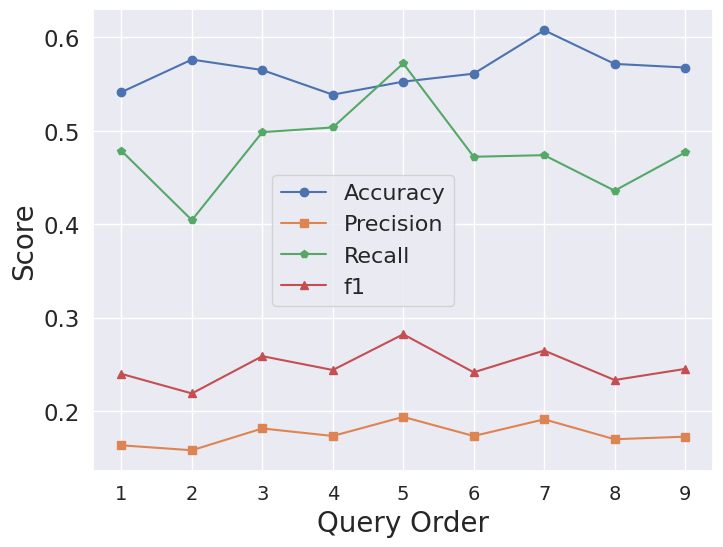

In [ ]:
from  matplotlib import ticker
from  matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=100)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

marker_list = ['o','s','p','^']
i=0
for score in ['Accuracy','Precision','Recall','f1']:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel('Query Order',fontsize=20)
    ax.set_ylabel('Score',fontsize=20)
    ax.set_xticklabels(range(0,11),fontsize=14)
    plt.rc('ytick', labelsize=14)
    #sns.lineplot(x='QueryOrder',y=score,data=pred_results,ax=ax,label=score,palette='tab10')
    plt.plot(pred_results['QueryOrder'],pred_results[score],marker=marker_list[i],label=score)
    i+=1
plt.legend(prop={"size":16},bbox_to_anchor=(0.6,0.5))
plt.show()

In [ ]:
def PerformanceComparing(target,good,query_order,metrics):
    task_performance = {}
    for task in tasks_list:
        cluster_task = clusters.loc[clusters['task']==task].copy()
        cluster_query = data_eval.loc[data_eval['task']==task].copy()
        cluster_query = pd.merge(cluster_query,cluster_task[['session',target]],on='session', how='left')

        good_cluster = good
        good_query = cluster_query.loc[cluster_query[target]==good_cluster]
        task_cluster_performance = {}

        rest_cluster = set(clusters[target])
        rest_cluster.remove(good_cluster)

        for i in rest_cluster:
            cluster = cluster_query.loc[cluster_query[target]==i].copy()
            if len(cluster):
                task_cluster_performance[i] = {}
                curr_session = ''
                task_cluster_performance[i]['Original'] = []
                task_cluster_performance[i]['Recommend'] = []
                task_cluster_performance[i]['Replace'] = []
                head_rows = query_order
                curr_row = 1
                for index, row in cluster.iterrows():
                    if row['session'] != curr_session:
                        if curr_row < head_rows:
                            curr_row += 1
                            continue
                        else:
                            curr_session = row['session']
                            curr_query_token = row['QueryToken']
                            good_query_type = good_query.loc[good_query['query_order']==head_rows].copy()
                            good_query_type['ShareTerm'] = good_query_type['QueryToken'].apply(
                                lambda x: len(set(curr_query_token) & set(x)))
                            good_query_type['similarity'] = (good_query_type['ShareTerm']/
                                                             good_query_type['QueryToken'].apply(lambda x: len(x)))
                            good_query_type.sort_values('similarity',ascending=False,ignore_index=True)
                            matched_sessions = good_query_type['session'].values[0:min(5,len(good_query_type))]

                    else:
                        curr_row = 1
                        task_cluster_performance[i]['Original'].append(
                            row[metrics]
                        )
                        curr_query_token = row['QueryToken']
                        good_query_type = good_query.copy()
                        good_query_type['ShareTermL'] = good_query_type['QueryToken'].apply(
                            lambda x: len(set(last_query_token) & set(x)))
                        good_query_type['ShareTermC'] = good_query_type['QueryToken'].apply(
                            lambda x: len(set(curr_query_token) & set(x)))
                        good_query_common = good_query_type.loc[good_query_type['ShareTermL']>0]
                        good_query_new = good_query_type.loc[good_query_type['ShareTermL']==0].copy()

                        if len(set(last_query_token) & set(curr_query_token)):
                            if len(curr_query_token) > len(last_query_token):
                                recommend_list = good_query_common.loc[good_query_common['TokenLength'] > len(last_query_token)].copy()
                            if len(curr_query_token) == len(last_query_token):
                                recommend_list = good_query_common.loc[good_query_common['TokenLength'] == len(last_query_token)].copy()
                            if len(curr_query_token) < len(last_query_token):
                                recommend_list = good_query_common.loc[good_query_common['TokenLength'] < len(last_query_token)].copy()
                        else:
                            recommend_list = good_query_new

                        recommend_list['similarity'] = (recommend_list['ShareTermC']/
                                                        recommend_list['QueryToken'].apply(lambda x: len(x)))
                        recommend_list.sort_values('similarity',ascending=False,ignore_index=True)
                        if len(recommend_list) != 0:
                            task_cluster_performance[i]['Recommend'].append(
                                list(recommend_list[metrics].values)
                            )
                        switched_list = good_query.loc[(good_query['session'].isin(matched_sessions)) & (good_query['query_order']==row['query_order'])]
                        if len(switched_list) != 0:
                            task_cluster_performance[i]['Replace'].append(
                                list(switched_list[metrics].values)
                            )
                    last_query = row['query']
                    last_query_token = row['QueryToken']

        task_performance[task] = task_cluster_performance
    return task_performance

In [ ]:
performance_result = PerformanceComparing('label_bi',1,1,'ndcg_r')

In [ ]:
rest_cluster = {0,1}
rest_cluster.remove(1)
original = []
recommend = []
for task in tasks_list:
    for cluster in rest_cluster:
        if performance_result[task][cluster]['Recommend'] != []:
            original.extend(performance_result[task][cluster]['Original'])
            recommend.extend([item[0] for item in performance_result[task][cluster]['Recommend']])

In [ ]:
print(len(original),len(recommend))
print(sum(original)/len(original),sum(recommend)/len(recommend))
print(stats.ttest_ind(recommend, original))

821 586
0.4582357519484857 0.4853623825204009
Ttest_indResult(statistic=0.7797353374783182, pvalue=0.43567799917375316)


In [ ]:
for score in ['dcg_rel','ndcg_r','rr_r']:
    performance_result = PerformanceComparing('label_bi',1,1,score)
    rest_cluster = {0,1}
    rest_cluster.remove(1)
    original = []
    recommend = []
    replace = []
    for task in tasks_list:
        for cluster in rest_cluster:
            if performance_result[task][cluster]['Recommend'] != []:
                original.extend(performance_result[task][cluster]['Original'])
                recommend.extend([sum(item[:5])/len(item[:5]) for item in
                                  performance_result[task][cluster]['Recommend']])
            if performance_result[task][cluster]['Replace'] != []:
                replace.extend([sum(item)/len(item) for item in performance_result[task][cluster]['Replace']])
    print(score)
    print(len(original),'\n',len(replace),'\n',len(recommend))
    print(sum(original)/len(original),'\n',sum(replace)/len(replace),'\n',sum(recommend)/len(recommend))
    print(stats.ttest_ind(replace, original))
    print(stats.ttest_ind(recommend, original))
    print(stats.ttest_ind(recommend, replace))

dcg_rel
821 
 658 
 586
0.2895721088007308 
 0.9381744002152788 
 1.0084601637320516
Ttest_indResult(statistic=7.836098477868895, pvalue=8.825272404197222e-15)
Ttest_indResult(statistic=8.716123333010817, pvalue=7.964261707763329e-18)
Ttest_indResult(statistic=0.8207759400535307, pvalue=0.4119314099283967)
ndcg_r
821 
 658 
 586
0.4582357519484857 
 0.5195934682091304 
 0.5270709250744823
Ttest_indResult(statistic=1.7482047329964647, pvalue=0.08063634595171723)
Ttest_indResult(statistic=2.158422871138242, pvalue=0.03106389828470144)
Ttest_indResult(statistic=0.22813119361259224, pvalue=0.8195818021739382)
rr_r
821 
 658 
 586
8.676004872107187 
 6.903394123606891 
 6.72076222980659
Ttest_indResult(statistic=-9.410455899208424, pvalue=1.8227347795891005e-20)
Ttest_indResult(statistic=-10.422465380559439, pvalue=1.497494787394201e-24)
Ttest_indResult(statistic=-0.9835311056732295, pvalue=0.32553766480222535)


In [ ]:
y_hat = {}
for q in range(1,4):
    X = SplitQueryOrder(query_order=q)
    model_list = model_members[q]
    yhats = [model.predict(X) for model in model_list]
    y_hat[q] = np.round(np.mean(yhats, axis=0))

In [ ]:
for q in range(1,4):
    print(q)
    for score in ['dcg_rel','ndcg_r','rr_r']:
        y_hat_label = y_hat[q]
        clusters['label_hat'] = y_hat_label
        performance_result = PerformanceComparing('label_hat',1,q,score)
        rest_cluster = {0,1}
        rest_cluster.remove(1)
        original = []
        recommend = []
        replace = []
        for task in tasks_list:
            if performance_result[task]:
                for cluster in rest_cluster:
                    if performance_result[task][cluster]['Recommend'] != []:
                        original.extend(performance_result[task][cluster]['Original'])
                        recommend.extend([sum(item[:3])/len(item[:3]) for item in
                                        performance_result[task][cluster]['Recommend']])
                    if performance_result[task][cluster]['Replace'] != []:
                        replace.extend([sum(item)/len(item) for item in performance_result[task][cluster]['Replace']])
        print(score)
        print(len(original),'\n',len(replace),'\n',len(recommend))
        print(sum(original)/len(original),'\n',sum(replace)/len(replace),'\n',sum(recommend)/len(recommend))
        print(stats.ttest_ind(replace, original))
        print(stats.ttest_ind(recommend, original))
        print(stats.ttest_ind(recommend, replace))

1
dcg_rel
736 
 623 
 604
0.31075200982202883 
 0.36177269913271715 
 0.41855139448237066
Ttest_indResult(statistic=0.621121045059117, pvalue=0.5346242979879583)
Ttest_indResult(statistic=1.3198930323846652, pvalue=0.18709650535492595)
Ttest_indResult(statistic=0.635741980335007, pvalue=0.5250633548734573)
ndcg_r
736 
 623 
 604
0.42812309271510335 
 0.4724621496151897 
 0.4486706300330189
Ttest_indResult(statistic=1.1874854424748347, pvalue=0.23524401059343006)
Ttest_indResult(statistic=0.582802267511878, pvalue=0.5601246222902787)
Ttest_indResult(statistic=-0.7862996845440906, pvalue=0.431844010810166)
rr_r
736 
 623 
 604
8.752717391304348 
 8.540663456393796 
 8.427704194260484
Ttest_indResult(statistic=-1.1252132254001928, pvalue=0.26069766525603577)
Ttest_indResult(statistic=-1.7323218740752797, pvalue=0.08344671525052554)
Ttest_indResult(statistic=-0.6078979709269354, pvalue=0.5433678246299141)
2
dcg_rel
578 
 482 
 442
0.3656066736694452 
 0.5171983469512527 
 0.502902822037544